In [1]:
import time
import tensorflow as tf
import numpy as np
import pygame
import random
import itertools
from collections import defaultdict
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop
from IPython.display import clear_output
import matplotlib.pyplot as plt

#dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print(tf.__version__)

pygame 2.0.0.dev6 (SDL 2.0.10, python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html
2.2.0


In [23]:
class snek:

    def __init__(self, size):
        self.size = size
        self.rewards = None
        self.action_space = 4
        self.actions = [0, 1, 2, 3]
        self.cstate = None
        self.dis = None
        self.snake = None
        self.head = None
        self.food = None
        self.scolor = (0, 0, 255)
        self.fcolor = (255, 0, 0)
        self.len = 1
    
    def reset(self):
        self.snake = []
        state = np.zeros((self.size, self.size))
        size = self.size
        x = random.randint(0, size - 1)
        y = random.randint(0, size - 1)
        foodx = random.randint(0, size - 1)
        foody = random.randint(0, size - 1) 
        self.food = (foodx, foody)
        self.head = (x, y)
        self.snake.append((x, y))
        state[x][y] = 1
        state[foodx][foody] = -1
        self.cstate = state
        return state
    
    def step(self, action):
        # Left = 0 Right = 1 Up = 2 Down = 3
        done = False
        food = False
        ate = False
        reward = 0
        dx, dy = 0, 0
        if action == 0:
            dx, dy = -1, 0
        elif action == 1:
            dx, dy = 1, 0
        elif action == 2:
            dx, dy = 0, -1
        elif action == 3:
            dx, dy = 0, 1
        
        
        x, y = self.head
        x += dy
        y += dx
        if x>=self.size or x<0 or y>=self.size or y<0:
            done = True
            print('Reached end')
        
        for i in self.snake[:-1]:
            if i == self.head:
                done = True
                print("ate itself")
                ate = True
        
        s = np.zeros((self.size, self.size))
        
        if not done:
            self.head = (x,y)
            self.snake.append(self.head)

            if self.head == self.food:
                reward = 1
                self.len += 1
                self.food = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
                food = True
                print('Food')

            elif self.len < len(self.snake):
                del self.snake[0]
            
            
            for i in self.snake:
                s[i[0]][i[1]] = 1
            s[self.food[0]][self.food[1]] = -1
            self.cstate = s

        if ate == True:
            reward = -15
        elif done == True:
            reward = -10
        elif food == True:
            reward = +20
        else:
            reward = +0.01
        return s, reward, done
        

In [24]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        Conv2D(30, kernel_size = (3,3), input_shape = input_shape, activation = tf.nn.relu, kernel_initializer = "he_uniform"),
        MaxPooling2D((2,2)),
        Conv2D(45, kernel_size = (5,5), activation = tf.nn.relu, kernel_initializer = "he_uniform"),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(512, activation = tf.nn.relu, kernel_initializer = "he_uniform"),
        Dense(4, activation = "linear", kernel_initializer = "he_uniform")
    ])
    model.compile(optimizer = Adam(0.001), loss = tf.keras.losses.Huber())
    return model

In [25]:
model = create_model((32, 32, 3))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 30)        840       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 30)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 45)        33795     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 45)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1125)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               576512    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

In [26]:
class DQL:

    def __init__(self, env, model, epsilon = 1, decay_rate = 0.999, min_epsilon = 0.1, discount_factor = 0.95, ermax = 500000, name = 'Default'):
        """
        Function which initializes all the values and parameters for the Deep Q Learning

        Input:
        env - Open AI Environment
        model - Q learning model specific to the environment
        epsilon - The rate of being greedy (Default = 1)
        decay_rate - Epsilon decay rate (Default = 0.99)
        min_epsilon - Minimum value of epsilon (Default = 0.1)
        discount_factor - Gamma value for RL (Default = 1)
        name - Model's Name (Default = 'Default)

        Returns:
        DQL Object
        """
        self.name = name
        self.env = env
        self.model = model
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.discount_factor = discount_factor
        self.min_epsilon = min_epsilon
        self.er = []
        self.ermax = ermax
        self.rewards = []
        self.mse = []
        self.batch_size = 0

    def predict(self, state):
        '''
        Helper function to reshape and predict
        '''
        state = np.expand_dims(state, axis = 0)
        return self.model.predict(state)

    def epsilon_policy(self, state, rand = False):
        '''
        Function which finds the action probabilities based on epsilon policy given a specific state

        Input:
        state - The current state of the environment

        Returns:
        Probabilities of all the actions
        ''' 

        if random.random() <= self.epsilon or rand == True:
            return random.randrange(self.env.action_space)
        
        else:
            return np.argmax(self.predict(state)[0])

    def plot(self, i, tot_reward, tot_loss):
        '''
        Function to plot mse and reward by epiode basis

        Input:
        i - Current episode number
        tot_reward - Total reward for current episode
        tot_loss - Total loss for current episode

        '''
        clear_output(wait = True)
        fig, ax = plt.subplots(1, 2, figsize = (12, 5))
        fig.suptitle("Episode : {} Reward: {} Loss: {} Epsilon: {}".format(i, tot_reward, round(tot_loss, 3), round(self.epsilon, 3)))
        ax[0].set_xlabel('Episodes')
        ax[0].set_ylabel('Rewards')
        ax[1].set_xlabel('Episodes')
        ax[1].set_ylabel('MSE')
        
        ax[1].plot(self.mse)
        ax[0].plot(self.rewards, label = 'Reward')
        ax[0].legend()
        ax[0].grid()
        ax[1].grid()
        plt.show()

    def prepopulate_er(self):
        '''
        Function to prepopulate the experience replay by batch size
        '''
        pygame.init()
        dis = pygame.display.set_mode((self.env.size *10, self.env.size *10))
        pygame.display.set_caption("AI Learns to play Snake")
        icon = pygame.image.load('/home/veeraraghavan/Desktop/DQL-Snake/Images/snake.png')
        pygame.display.set_icon(icon)
        state = self.env.reset()
        i = 0
        while i < self.batch_size:
            j = 0
            action = self.epsilon_policy(state)
            avg_reward = 0
            states = []
            states.append(state)
            while j < 3:
                dis.fill((0, 0, 0))
                next_state, reward, done = self.env.step(action)
                if j == 2:
                    action = self.epsilon_policy(np.stack(states[:-1]), True)
                avg_reward += reward
                j+=1

                for event in pygame.event.get():
                    if event.type == pygame.QUIT:
                        gameover = True
                for square in self.env.snake:
                    pygame.draw.rect(dis, self.env.scolor, [square[1] * 10, square[0] * 10, 10, 10])
                pygame.draw.rect(dis, self.env.fcolor, [self.env.food[1] * 10, self.env.food[0] * 10, 10, 10])
                pygame.display.update()
                if done:
                    state = env.reset()
                    break
                else:
                    state = next_state
                    states.append(state)
                #time.sleep(0.01)
            
            while(len(states)!= 4):
                states.append(states[-1])

            stack = np.stack(states[:-1], axis = -1)
            next_stack = np.stack(states[1:], axis = -1)
            self.er.append((stack, action, reward, next_stack, done))
            i+=1
        pygame.quit()  

    
    def update_network(self):
        '''
        Function which updates the network to the target q values
        '''

        samples = random.sample(self.er, self.batch_size)
        States = np.array([s[0] for s in samples])
        Next_States = np.array([s[3] for s in samples])
        print(States.shape)
        
        target = self.model.predict(States)
        target_next = self.model.predict(Next_States)

        for j,s in enumerate(samples):
            state, action, reward, next_state, done = s
            if done:
                target[j][action] = reward
            else:
                target[j][action] = reward + (self.discount_factor * np.max(target_next[j]))
        
        hist = self.model.fit(States, target, batch_size = self.batch_size, verbose = False)
        return round(hist.history['loss'][0], 3)

    def learn(self, noe, batch_size):
        '''
        Function which trains the agent

        Input:
        noe - No of episodes to train
        batch_size - Experience replay batch train size
        '''
        
        self.batch_size = batch_size
        self.prepopulate_er()
        print('Populated_er')

        for i in range(noe):
            tot_reward = 0
            tot_loss = 0
            length = 0
            self.env.len = 0
            self.epsilon = (max(self.min_epsilon, self.epsilon*self.decay_rate))
            pygame.init()
            dis = pygame.display.set_mode((self.env.size *10, self.env.size *10))
            pygame.display.set_caption("AI Learns to play Snake")
            icon = pygame.image.load('/home/veeraraghavan/Desktop/DQL-Snake/Images/snake.png')
            pygame.display.set_icon(icon)
            gameover = False
            state = env.reset()
            while gameover != True:
                j = 0
                action = self.epsilon_policy(state, True)
                avg_reward = 0
                states = []
                states.append(state)
                while j < 3:
                    dis.fill((0, 0, 0))
                    next_state, reward, done = self.env.step(action)
                    length += 1
                    if j == 2:
                        action = self.epsilon_policy(np.stack(states, axis = -1))
                    avg_reward += reward
                    j+=1
                    for event in pygame.event.get():
                        if event.type == pygame.QUIT:
                            gameover = True
                    for square in self.env.snake:
                        pygame.draw.rect(dis, self.env.scolor, [square[1] * 10, square[0] * 10, 10, 10])
                    pygame.draw.rect(dis, self.env.fcolor, [self.env.food[1] * 10, self.env.food[0] * 10, 10, 10])
                    pygame.display.update()
                    if done:
                        state = env.reset()
                        gameover = True
                        break
                    else:
                        state = next_state
                        states.append(state)
                    time.sleep(0.01)
                
                while(len(states)!= 4):
                    states.append(states[-1])

                stack = np.stack(states[:-1], axis = -1)
                next_stack = np.stack(states[1:], axis = -1)
                self.er.append((stack, action, avg_reward, next_stack, done))
                if(len(self.er)> self.ermax):
                    er[:] = er[1 : self.ermax]
                tot_reward += avg_reward
                

            if i % 5 == 0:
                tot_loss = self.update_network()
                tot_loss/=length
                self.mse.append(tot_loss)
            self.rewards.append(tot_reward)
            self.plot(i, tot_reward, tot_loss)

In [20]:
env = snek(32)

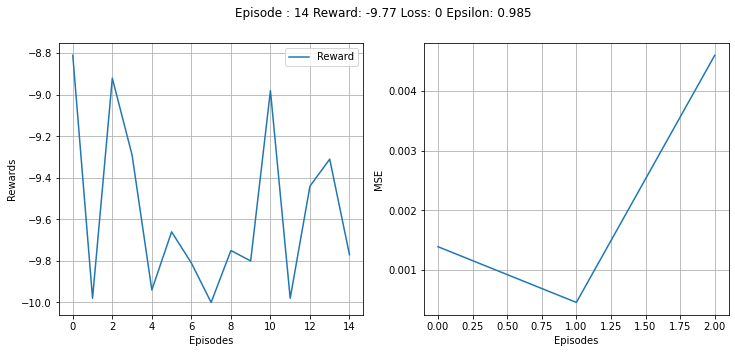

KeyboardInterrupt: 

In [21]:
dql = DQL(env, model)
dql.learn(2000, 16)


In [22]:
pygame.quit()